In [1]:
import matplotlib
from matplotlib.animation import ArtistAnimation
import numpy as np

import metpy.plots as mpplots

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from datetime import datetime, timedelta

from siphon.radarserver import RadarServer

print(" and here we go! ")

 and here we go! 


In [2]:
# Radar Server (NOAA Weather Radar)

rs = RadarServer('http://tds-nexrad.scigw.unidata.ucar.edu/thredds/radarServer/nexrad/level2/S3/')

print(" got radar server ")

 got radar server 


In [3]:
def raw_to_masked_float(var, data):
   
    if var._Unsigned:
        data = data & 255

    # Mask missing points
    data = np.ma.array(data, mask=data==0)

    # Convert to float using the scale and offset
    return data * var.scale_factor + var.add_offset

def polar_to_cartesian(az, rng):
    az_rad = np.deg2rad(az)[:, None]
    x = rng * np.sin(az_rad)
    y = rng * np.cos(az_rad)
    return x, y

def new_map(fig, lon, lat):
    # Create projection centered on the radar. This allows us to use x
    # and y relative to the radar.
    proj = ccrs.LambertConformal(central_longitude=lon, central_latitude=lat)

    # New axes with the specified projection
    ax = fig.add_axes([0.02, 0.02, 0.96, 0.96], projection=proj)

    # Add coastlines and states, etc.
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=2)
    ax.add_feature(cfeature.STATES.with_scale('50m'))
    ax.add_feature(cfeature.OCEAN.with_scale('50m'))
    ax.add_feature(cfeature.LAND.with_scale('50m'))
    
    return ax


print(" done defining functions ")

 done defining functions 


In [4]:
# Get the historical radar data, selecting radar closest to location provided below
# The date is encoded using datetime, and we're asking for data for that time and the rest of the hour

# Here we area asking for a date and time corresponding to Hurricane Sandy approaching landfall

query = rs.query()
dt = datetime(2013, 5, 20, 20) # Our specified time

# Specify a lon/lat and let system find the nearest radar
query.lonlat_point(-73.687, 41.175).time_range(dt, dt + timedelta(hours=1)) # finds radar closest to given point

# That does not always work, so as a backup you can explicitly specify the radar desired
query.stations('KTLX').time_range(dt, dt + timedelta(hours=1))

# Get the catalogue and look inside

cat = rs.get_catalog(query)

print(" Here are our datasets... ")
cat.datasets



 Here are our datasets... 


['KTLX20130520_200356_V06.gz', 'KTLX20130520_200811_V06.gz', 'KTLX20130520_201229_V06.gz', 'KTLX20130520_201643_V06.gz', 'KTLX20130520_202058_V06.gz', 'KTLX20130520_202511_V06.gz', 'KTLX20130520_202928_V06.gz', 'KTLX20130520_203346_V06.gz', 'KTLX20130520_203800_V06.gz', 'KTLX20130520_204215_V06.gz', 'KTLX20130520_204630_V06.gz', 'KTLX20130520_205045_V06.gz', 'KTLX20130520_205459_V06.gz', 'KTLX20130520_205914_V06.gz']

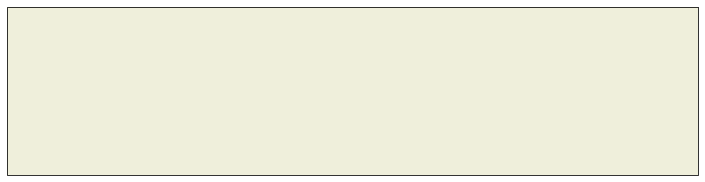

In [5]:
# Extract the first dataset

ds = cat.datasets[0]

# This initiates remote access, without having to download the entire file

data = ds.remote_access()

# Start making the figure.  We defined the new_map function above
# Central longitude and latitude are specified as lon/lat of the selected radar site

fig = plt.figure(figsize=(10, 7.5))
ax = new_map(fig, data.StationLongitude, data.StationLatitude)

# Set the plot limits to nice values, knowing what my radar image would look like

ax.set_extent([-98.5, -96, 35, 35.5])



In [6]:
# Let's look inside the dataset, to see what variables are contained within
# It's a long and messy list.  You can click on left side of the output window to reduce size of visible window

cat.datasets[0].remote_access().variables

OrderedDict([('Reflectivity_HI',
              <siphon.cdmr.dataset.Variable at 0x7f57228d7250>),
             ('timeR_HI', <siphon.cdmr.dataset.Variable at 0x7f57228ce450>),
             ('elevationR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f57228cec50>),
             ('azimuthR_HI', <siphon.cdmr.dataset.Variable at 0x7f57228cea90>),
             ('distanceR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f57228ce510>),
             ('numRadialsR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f57228b5c50>),
             ('numGatesR_HI',
              <siphon.cdmr.dataset.Variable at 0x7f57228b5950>),
             ('Reflectivity',
              <siphon.cdmr.dataset.Variable at 0x7f57228b5710>),
             ('timeR', <siphon.cdmr.dataset.Variable at 0x7f57228b5590>),
             ('elevationR', <siphon.cdmr.dataset.Variable at 0x7f57228dbcd0>),
             ('azimuthR', <siphon.cdmr.dataset.Variable at 0x7f57228db890>),
             ('distanceR', <siphon.cd

In [7]:
# Are we plotting 'reflectivity' or radial 'velocity'?

doplot='reflectivity'
#doplot='velocity'

# Define our color table

if(doplot == 'reflectivity'):
    ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSReflectivity', 5, 5) # NWS reflectivity colortable
elif(doplot == 'velocity'):
    ref_norm, ref_cmap = mpplots.ctables.registry.get_with_steps('NWSVelocity', 0, 1) # NWS radial velocity colortable
    #
#


# Now grab data for a set of times.
# We are currently grabbing base reflectivity (Reflectivity_HI) for plotting
# The azimuthR_HI and distanceR_HI variables contain information on location relative to radar

meshes = []
for ds_name in cat.datasets:
    # After looping over the list of sorted datasets, pull the actual Dataset object out
    # of our list of items and access over CDMRemote
    print(" I am fetching ", ds_name)
    data = cat.datasets[ds_name].remote_access()
    
    # Pull out the data of interest
    sweep = 0
    if(doplot == 'reflectivity'):
        rng = data.variables['distanceR_HI'][:]
        az = data.variables['azimuthR_HI'][sweep]
        ref_var = data.variables['Reflectivity_HI']
    elif(doplot == 'velocity'):
        rng = data.variables['distanceV_HI'][:]
        az = data.variables['azimuthV_HI'][sweep]
        ref_var = data.variables['RadialVelocity_HI']
    #

    # Convert data to float and coordinates to Cartesian
    ref = raw_to_masked_float(ref_var, ref_var[sweep])
    x, y = polar_to_cartesian(az, rng)

    # Plot the data and the timestamp
    mesh = ax.pcolormesh(x, y, ref, cmap=ref_cmap, norm=ref_norm, zorder=0)
    text = ax.text(0.7, 0.02, data.time_coverage_start, transform=ax.transAxes,
                   fontdict={'size':16})
    
    # Collect the things we've plotted so we can animate
    meshes.append((mesh, text))

print()
print(" Done getting data! ")

 I am fetching  KTLX20130520_200356_V06.gz
 I am fetching  KTLX20130520_200811_V06.gz
 I am fetching  KTLX20130520_201229_V06.gz
 I am fetching  KTLX20130520_201643_V06.gz
 I am fetching  KTLX20130520_202058_V06.gz
 I am fetching  KTLX20130520_202511_V06.gz
 I am fetching  KTLX20130520_202928_V06.gz
 I am fetching  KTLX20130520_203346_V06.gz
 I am fetching  KTLX20130520_203800_V06.gz
 I am fetching  KTLX20130520_204215_V06.gz
 I am fetching  KTLX20130520_204630_V06.gz
 I am fetching  KTLX20130520_205045_V06.gz
 I am fetching  KTLX20130520_205459_V06.gz
 I am fetching  KTLX20130520_205914_V06.gz

 Done getting data! 


In [8]:
# Use matplotlib to do the conversion to HTML5 video

matplotlib.rcParams['animation.html'] = 'html5'

# Create the animation!

print(" Making the animation.... please be patient... ")
ArtistAnimation(fig, meshes, interval=1250) # controls framerate


 Making the animation.... please be patient... 
